In [1]:
#imports
#text Encoding
import codecs
#regex
import glob
#concurency
import multiprocessing
#os
import os
#pprint
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word to vector
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plottion
import matplotlib.pyplot as plt
#pandas
import pandas as pd
#visualization
import seaborn as sns

In [2]:
#Process data

#clean data
nltk.download('punkt') #tokenizer
nltk.download('stopwords') #useless words

[nltk_data] Downloading package punkt to /home/mrlipdx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrlipdx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#getting all the book filenames
book_filenames = sorted(glob.glob("./data/*.txt"))

for book_filename in book_filenames:
    print(book_filename)

./data/got1.txt
./data/got2.txt
./data/got3.txt
./data/got4.txt
./data/got5.txt


In [4]:
corpus_raw = u''

for book_filename in book_filenames:
    print("Reading '{0}".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()


Reading './data/got1.txt
Corpus is now 1770659 characters long

Reading './data/got2.txt
Corpus is now 4071041 characters long

Reading './data/got3.txt
Corpus is now 6391405 characters long

Reading './data/got4.txt
Corpus is now 8107945 characters long

Reading './data/got5.txt
Corpus is now 9719485 characters long



In [5]:
#split corpus into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

#string to list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]",u" ", raw)
    words = clean.split()
    return words

sentences = []
for raw_sentence in raw_sentences:
    if(len(raw_sentence) > 0):
        sentences.append(sentence_to_wordlist(raw_sentence))
 
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [6]:
token_count = sum([len(sentences) for sentence in sentences])
print("The book corpus cointains {0:,} tokens.".format(token_count))

The book corpus cointains 16,606,961,424 tokens.


In [7]:
#Traning word2vec

#dimensionality of the resulting word vectors.
num_features = 300

#min word count threshold
min_word_count = 3

#number of threads to run in parallel
num_workers = multiprocessing.cpu_count()

#contect window lenght
context_size = 7

#downsample setting for frequent words
downsampling = 1e-3

#seed for debuging
seed = 42

#model filename
model_filename = os.path.join("trained", "thrones2vec.w2v")

#checks if the model is already in memory
if(not os.path.exists(model_filename)):
    #creating w2v
    thrones2vec = w2v.Word2Vec(
        sg=1,
        seed=seed,
        workers=num_workers,
        size=num_features,
        min_count=min_word_count,
        window=context_size,
        sample=downsampling
    )
    #traning
    thrones2vec.build_vocab(sentences)
    print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))
    thrones2vec.train(sentences, total_examples = len(sentences),
                      epochs = 12)

    #saving the model
    if not os.path.exists("trained"):
        os.makedirs("trained")

    thrones2vec.save(model_filename)
else :
    thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [8]:
#dimension reduction
    
all_words_2d_filename = os.path.join("output", "allWords2d.npy")

if(not os.path.exists(model_filename)):   
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
    all_words = thrones2vec.wv.syn0
    all_words_2d = tsne.fit_transform(all_word_vectors_matrix)

    if not os.path.exists("output"):
        os.makedirs("output")

    np.save(ALL_WORD_VECTIRS_MATRIX_2D_FILENAME, all_word_vectors_matrix_2d)
else:
    all_words_2d = np.load(all_words_2d_filename)

word     object
x       float64
y       float64
dtype: object
         word          x          y
0        sour  50.832397   1.868584
1       Magic -11.392491 -18.275434
2       edges  31.684368 -24.827042
3      handed  37.707874  -3.653518
4  cadaverous  -5.081497  -1.024914
5      itched  44.662277 -15.283196
6    kitchens  58.361511  -1.139143
7      demons -11.240300  -1.986545
8    outlines  12.177766 -36.202560
9  figurehead  35.426441 -26.741135


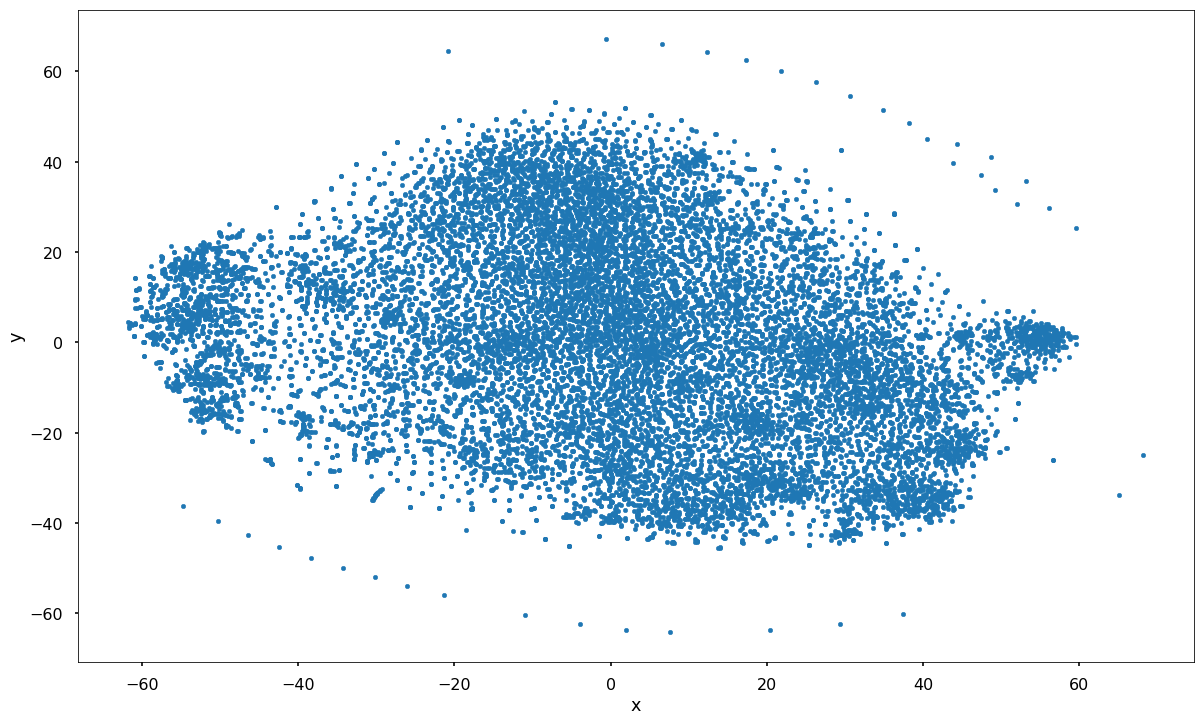

In [9]:
%matplotlib inline
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_words_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
print(points.dtypes)
print(points.head(10))


sns.set_context("poster")
points.plot.scatter("x", "y", s=20, figsize=(20, 12))

        word          x         y
228   CLYDAS -54.340828 -1.542419
696    RYGER -58.523438 -0.165521
831  scholar -56.196194  1.846950
834   hugely -57.239063 -0.820589
962     DIRK -53.299873 -0.763093


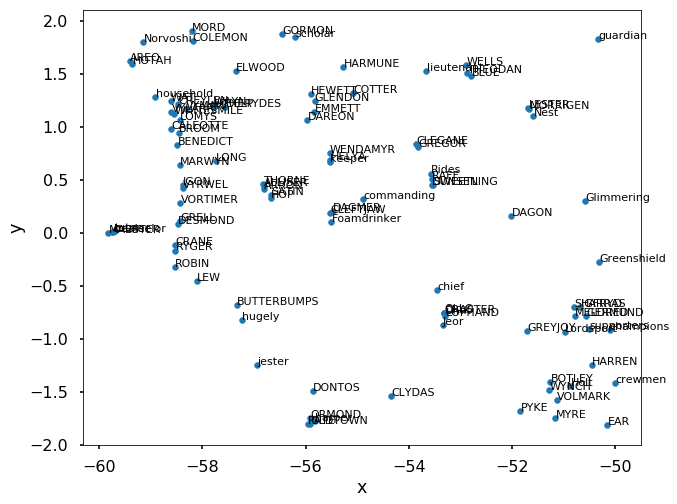

In [10]:
def plot_region(points, x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    print(slice.head())
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
   
plot_region(points, x_bounds=(-60, -50), y_bounds=(-2, 2))


          word         x          y
320    quivers  2.217935 -27.072725
456    flanked  3.575557 -24.522900
840     pulpit  3.654876 -24.310074
1012  spearmen  2.252943 -25.379478
1139     Flour  5.585111 -25.464527


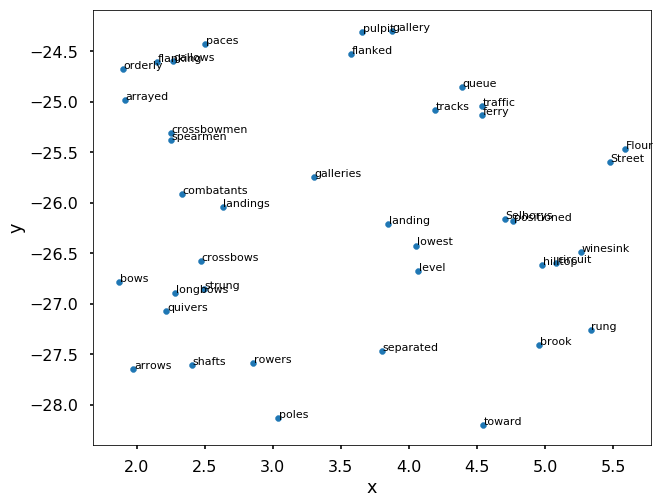

In [11]:
def plot_region_around(points, center_word, size = (4,4)):
    ent = points.loc[points['word'] == center_word].as_matrix()[0]
    centerX = ent[1]
    centerY = ent[2]
    plot_region(points, x_bounds=(centerX - size[0]/2, centerX + size[0]/2)
                       ,y_bounds=(centerY - size[1]/2, centerY + size[0]/2))
    
plot_region_around(points, "landing")

In [12]:
thrones2vec.wv.most_similar("Pyke")

[('Cotter', 0.6590700149536133),
 ('Reaper', 0.580957293510437),
 ('Wyk', 0.5703393220901489),
 ('Dagon', 0.5531452894210815),
 ('ASHA', 0.5510178804397583),
 ('Islands', 0.5338352918624878),
 ('Talon', 0.5332853198051453),
 ('Towers', 0.5311135053634644),
 ('Tarle', 0.51962810754776),
 ('Bitch', 0.5174728631973267)]